In [36]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings("ignore")
import re
from nltk.corpus import stopwords
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks, models, layers
import nltk

%matplotlib inline

### Read Data

In [2]:
train_data = pd.read_csv('labeledTrainData.tsv', header = 0, delimiter = '\t', quoting = 0)
train_data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [ ]:
test_data = pd.read_csv('')

### Data Shape

In [3]:
train_data.shape

(25000, 3)

### Data length

In [4]:
train_length = train_data['review'].apply(len)
train_length.head()

0    2302
1     946
2    2449
3    2245
4    2231
Name: review, dtype: int64

#### EDA

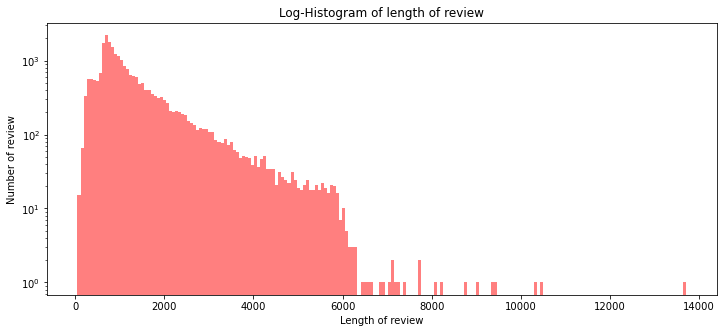

In [5]:
plt.figure(figsize = (12,5))
plt.hist(train_length, bins = 200, alpha = 0.5, color = 'r', label = 'word')
plt.yscale('log', nonposy = 'clip') # y축의 범위를 log단위로 바꿔줌
plt.title('Log-Histogram of length of review')
plt.xlabel('Length of review')
plt.ylabel('Number of review')
plt.show()

### Data Describe

In [6]:
train_length.describe()

count    25000.000000
mean      1327.710560
std       1005.239246
min         52.000000
25%        703.000000
50%        981.000000
75%       1617.000000
max      13708.000000
Name: review, dtype: float64

### Data's Outlier

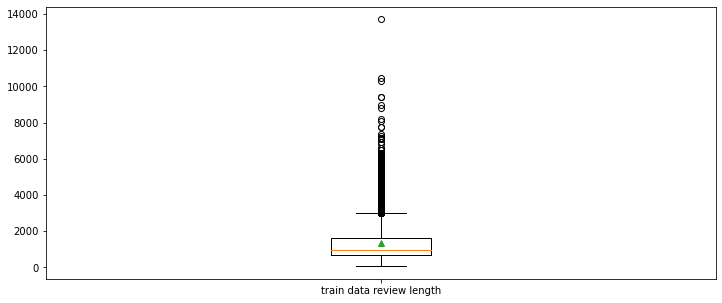

In [7]:
plt.figure(figsize = (12,5))
plt.boxplot(train_length, labels = ['train data review length'], showmeans = True)
plt.show()

### Word Cloud

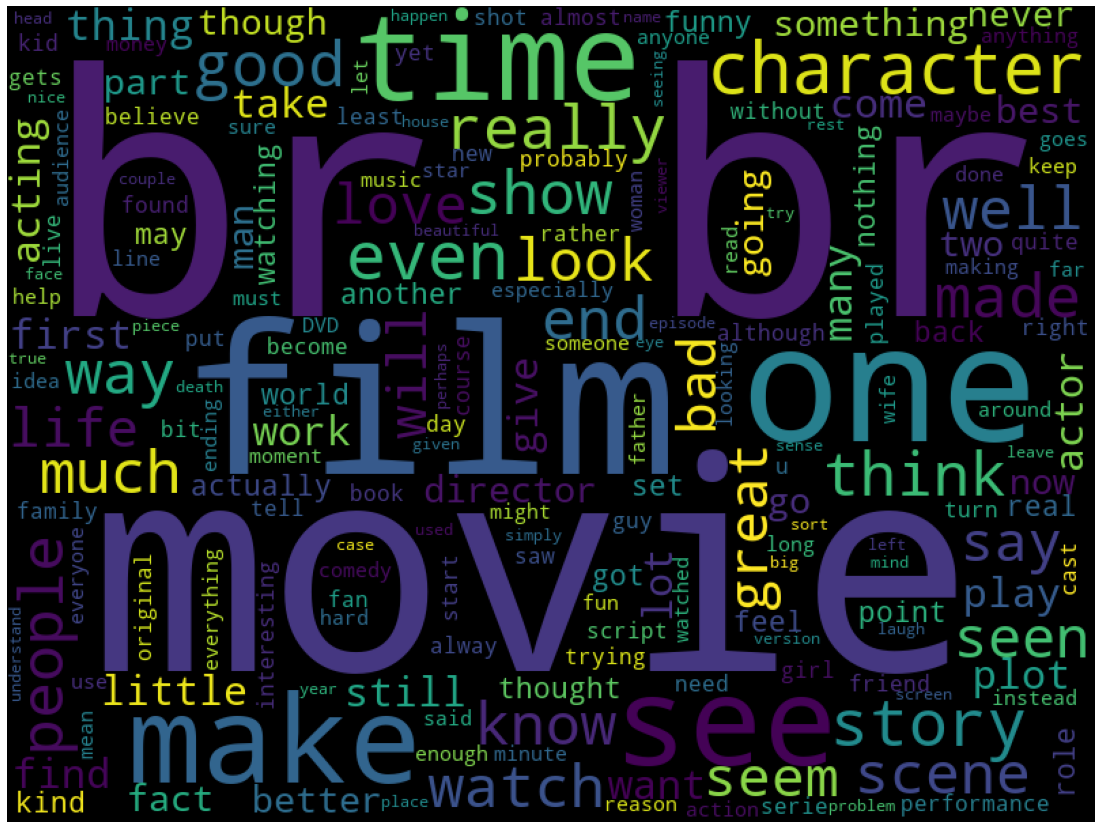

In [8]:
from wordcloud import WordCloud

cloud = WordCloud(width = 800, height = 600).generate(' '.join(train_data['review']))
plt.figure(figsize = (20,15))
plt.imshow(cloud)
plt.axis('off')
plt.show()

### Target Distribution

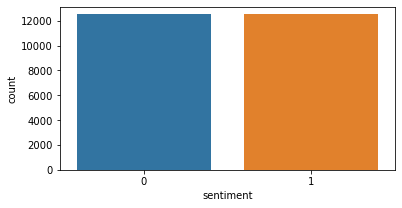

In [9]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6,3)
sns.countplot(train_data['sentiment'])
plt.show()

In [10]:
print('Positive Reviews Count : {}'.format(train_data['sentiment'].value_counts()[1]))
print('Negative Reviews Count : {}'.format(train_data['sentiment'].value_counts()[0]))

Positive Reviews Count : 12500
Negative Reviews Count : 12500


### Word Count

In [11]:
train_word_counts = train_data['review'].apply(lambda x : len(x.split(' ')))
train_word_counts

0        433
1        158
2        378
3        379
4        367
        ... 
24995     95
24996    174
24997    127
24998    197
24999    184
Name: review, Length: 25000, dtype: int64

#### EDA

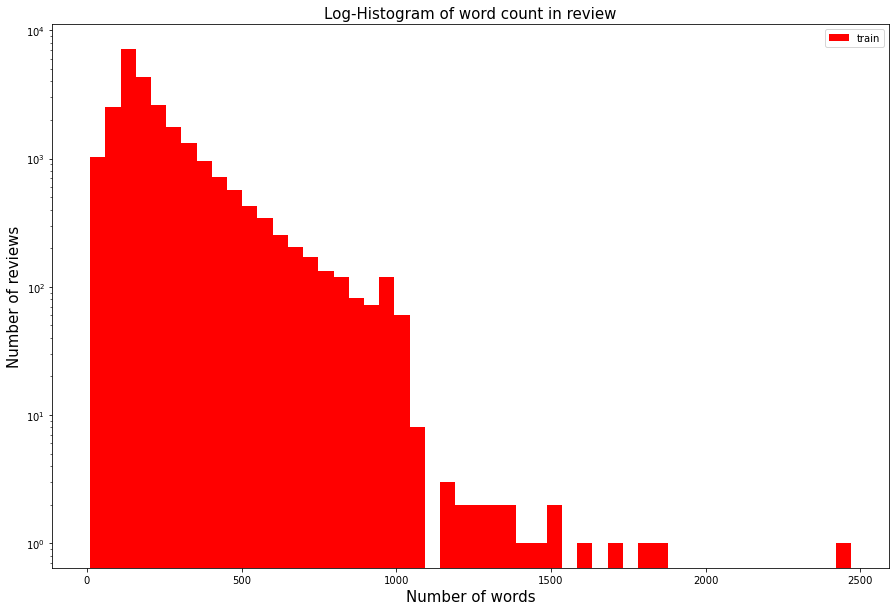

In [12]:
plt.figure(figsize = (15,10))
plt.hist(train_word_counts, bins = 50, facecolor = 'r', label = 'train')
plt.title('Log-Histogram of word count in review', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize = 15)
plt.ylabel('Number of reviews', fontsize = 15)
plt.show()

### Word Count Describe

In [13]:
train_word_counts.describe()

count    25000.000000
mean       233.786240
std        173.745845
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: review, dtype: float64

### Data Info

In [16]:
qmarks = np.mean(train_data['review'].apply(lambda x : '?' in x))
fullstop = np.mean(train_data['review'].apply(lambda x : '.' in x))
capital_first = np.mean(train_data['review'].apply(lambda x : x[0].isupper()))
capitals = np.mean(train_data['review'].apply(lambda x : max([y.isupper() for y in x])))
numbers = np.mean(train_data['review'].apply(lambda x : max([y.isdigit() for y in x])))

print('How many Question Mark : {:.2f}%'.format(qmarks * 100))
print('How many Period Mark : {:.2f}%'.format(fullstop * 100))
print('How many Capital First : {:.2f}%'.format(capital_first * 100))
print('How many Capitals : {:.2f}%'.format(capitals * 100))
print('How many Numbers : {:.2f}%'.format(numbers * 100))

How many Question Mark : 29.55%
How many Period Mark : 99.69%
How many Capital First : 92.84%
How many Capitals : 99.59%
How many Numbers : 56.66%


### Data Preprocessing

In [20]:
def preprocessing(review, remove_stopwords = False):
    review_text = BeautifulSoup(review, 'html5lib').get_text()
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    words = review_text.lower().split()
    
    if remove_stopwords:
        stops = set(stopwords.words('english'))
        words = [w for w in words if not w in stops]
        clean_review = ' '.join(words)
    else:
        clean_review = ' '.join(words)
    return clean_review

In [21]:
train_data['clean_review'] = train_data['review'].apply(lambda x : preprocessing(review = x, remove_stopwords=True))

train_data['clean_review'][0]

'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate workin

### Tokenize

In [29]:
MAX_WORDS = 25000

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_data['clean_review'])
total_words = len(tokenizer.word_index) + 1
text_sequences_tr = tokenizer.texts_to_sequences(train_data['clean_review'])
text_sequences_te = tokenizer.texts_to_sequences(test_data['clean_'])
total_words

74066

### Data Split & Concat

In [33]:
max_sequence_len = max([len(x) for x in text_sequences])
padded_sequences = np.array(pad_sequences(text_sequences, maxlen=max_sequence_len, padding = 'pre'))
labels = np.array(train_data['sentiment'])

(20000, 1322) (20000,) (5000, 1322) (5000,)


### Modeling